# **Deforum Stable Diffusion v0.7**
[Stable Diffusion](https://github.com/CompVis/stable-diffusion) by Robin Rombach, Andreas Blattmann, Dominik Lorenz, Patrick Esser, Björn Ommer and the [Stability.ai](https://stability.ai/) Team. [K Diffusion](https://github.com/crowsonkb/k-diffusion) by [Katherine Crowson](https://twitter.com/RiversHaveWings). Notebook by [deforum](https://discord.gg/upmXXsrwZc)

[Quick Guide](https://docs.google.com/document/d/1RrQv7FntzOuLg4ohjRZPVL7iptIyBhwwbcEYEW2OfcI/edit?usp=sharing) to Deforum v0.7

In [ ]:
#@markdown **NVIDIA GPU**
import subprocess, os, sys
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(f"{sub_p_res[:-1]}")

Tesla T4, 15109 MiB, 15109 MiB


# Setup

In [ ]:
#@markdown **Environment Setup**
import subprocess, time, gc, os, sys

def setup_environment():
    start_time = time.time()
    print_subprocess = False
    use_xformers_for_colab = True
    try:
        ipy = get_ipython()
    except:
        ipy = 'could not get_ipython'
    if 'google.colab' in str(ipy):
        print("..setting up environment")
        
        all_process = [
            ['pip', 'install', 'torch==1.12.1+cu113', 'torchvision==0.13.1+cu113', '--extra-index-url', 'https://download.pytorch.org/whl/cu113'],
            ['pip', 'install', 'omegaconf==2.2.3', 'einops==0.4.1', 'pytorch-lightning==1.7.4', 'torchmetrics==0.9.3', 'torchtext==0.13.1', 'transformers==4.21.2', 'safetensors', 'kornia==0.6.7'],
            ['git', 'clone', 'https://github.com/deforum-art/deforum-stable-diffusion'],
            ['pip', 'install', 'accelerate', 'ftfy', 'jsonmerge', 'matplotlib', 'resize-right', 'timm', 'torchdiffeq','scikit-learn','torchsde','open-clip-torch','numpngw'],
        ]
        for process in all_process:
            running = subprocess.run(process,stdout=subprocess.PIPE).stdout.decode('utf-8')
            if print_subprocess:
                print(running)
        with open('deforum-stable-diffusion/src/k_diffusion/__init__.py', 'w') as f:
            f.write('')
        sys.path.extend([
            'deforum-stable-diffusion/',
            'deforum-stable-diffusion/src',
        ])
        if use_xformers_for_colab:

            print("..installing xformers")

            all_process = [['pip', 'install', 'triton==2.0.0.dev20220701']]
            for process in all_process:
                running = subprocess.run(process,stdout=subprocess.PIPE).stdout.decode('utf-8')
                if print_subprocess:
                    print(running)

            v_card_name = subprocess.run(['nvidia-smi', '--query-gpu=name', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
            if 't4' in v_card_name.lower():
                name_to_download = 'T4'
            elif 'v100' in v_card_name.lower():
                name_to_download = 'V100'
            elif 'a100' in v_card_name.lower():
                name_to_download = 'A100'
            elif 'p100' in v_card_name.lower():
                name_to_download = 'P100'
            elif 'a4000' in v_card_name.lower():
                name_to_download = 'Non-Colab/Paperspace/A4000'
            elif 'p5000' in v_card_name.lower():
                name_to_download = 'Non-Colab/Paperspace/P5000'
            elif 'quadro m4000' in v_card_name.lower():
                name_to_download = 'Non-Colab/Paperspace/Quadro M4000'
            elif 'rtx 4000' in v_card_name.lower():
                name_to_download = 'Non-Colab/Paperspace/RTX 4000'
            elif 'rtx 5000' in v_card_name.lower():
                name_to_download = 'Non-Colab/Paperspace/RTX 5000'
            else:
                print(v_card_name + ' is currently not supported with xformers flash attention in deforum!')

            if 'Non-Colab' in name_to_download:
                x_ver = 'xformers-0.0.14.dev0-cp39-cp39-linux_x86_64.whl'
            else:
                x_ver = 'xformers-0.0.13.dev0-py3-none-any.whl'

            x_link = 'https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/' + name_to_download + '/' + x_ver

            all_process = [
                ['wget', '--no-verbose', '--no-clobber', x_link],
                ['pip', 'install', x_ver],
            ]

            for process in all_process:
                running = subprocess.run(process,stdout=subprocess.PIPE).stdout.decode('utf-8')
                if print_subprocess:
                    print(running)
    else:
        sys.path.extend([
            'src'
        ])
    end_time = time.time()
    print(f"..environment set up in {end_time-start_time:.0f} seconds")
    return

setup_environment()

import torch
import random
import clip
from IPython import display
from types import SimpleNamespace
from helpers.save_images import get_output_folder
from helpers.settings import load_args
from helpers.render import render_animation, render_input_video, render_image_batch, render_interpolation
from helpers.model_load import make_linear_decode, load_model, get_model_output_paths
from helpers.aesthetics import load_aesthetics_model

..setting up environment
..installing xformers
..environment set up in 29 seconds


In [ ]:
#@title **OUR FUNCTIONS**
import numpy as np
'''
from transformers import GPT2TokenizerFast
my_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(prompt):
  n_token = len(my_tokenizer(prompt)['input_ids'])
  return n_token


def validate_prompts(prompts, max_token=75):
  for k in prompts:
    p = prompts[k]
    n = count_tokens(p)
    if(n > max_token):
      print("ERROR : Prompt is more than " + str(max_token) + " tokens. Prompt : " + str(p))
      print("Total : " + str(n) + " tokens")
      assert False
'''

def print_prompts(p):
  for key in p:
    print(key, p[key])
#    print("Tokens : " + str(count_tokens(p[key])))


def generate_prompts(prompt_list, interval=10, max_t=1000, shuffle_list=False):
  new_prompts = {}
  t = 0
  while(t < max_t):
    if(shuffle_list):
      np.random.shuffle(prompt_list)

    for p in prompt_list:
      new_prompts[t] = p
      t += interval

  return new_prompts


def merge_timecodes(prompts_1, prompts_2):
  new_prompts = {}
  keys_1 = list(prompts_1.keys())
  keys_2 = list(prompts_2.keys())
  times = np.sort(np.concatenate((keys_1, keys_2)))

  i1 = 0
  i2 = 0
  k1 = keys_1[i1]
  k2 = keys_2[i2]
  p1 = prompts_1[k1]
  p2 = prompts_2[k2]

  max_t = times[-1]

  for i, t in enumerate(times):
    new_prompts[t] = p1 + ", " + p2

    if(i < (len(times) - 1)):
      next_time = times[i+1]
      if(i1 < (len(keys_1)-1)) and (next_time >= keys_1[i1+1]):
        i1 += 1
      if(i2 < (len(keys_2)-1)) and (next_time >= keys_2[i2+1]):
        i2 += 1

      k1 = keys_1[i1]
      k2 = keys_2[i2]
      p1 = prompts_1[k1]
      p2 = prompts_2[k2]

  return new_prompts


# Unused
def loop_styles(prompts, styles):
    n_styles = len(styles)

    times = list(prompts.keys())
    for i, time in enumerate(times):

      if(shuffle_styles):
        np.random.seed(i + run_id)
        np.random.shuffle(styles)

      if(i < len(times)-1):
        next_time = times[i+1]
        interval = next_time - time
        step = int(interval/n_styles)
      bare_prompt = prompts[time]

      for j, style in enumerate(styles):
        prompts[time + j*step] = bare_prompt + "," + style


def add_modifier(prompt_list, target_indices, modifier):
  for i in target_indices:
    prompt_list[i] = prompt_list[i] + "," + modifier




def add_beats(s):
  return s

def generate(times, nominal_value=0.75, transition_value=0.6, transition_range=0, time_offset=0):
    str_dict = {}
    for i, time in enumerate(times):
      t = time - time_offset
      if(t < 0):
        t = 0
      if(i == 0):
        str_dict[t] = nominal_value
      else:
        if(t > 2*transition_range):
          str_dict[t-(2*transition_range)] = nominal_value
          str_dict[t-(transition_range)] = transition_value
        str_dict[t+(transition_range)] = transition_value
        str_dict[t+(2*transition_range)] = nominal_value

    return str_dict

def convert_to_str(str_dict, add_brackets=False):
    result = ""
    times = list(str_dict.keys())
    times = np.sort(times)
    for time in times:
      s = str_dict[time]
      if(add_brackets):
        result = result + str(time) + ":(" + str(s) + "),"
      else:
        result = result + str(time) + ":" + str(s) + ","

    return result[:-1]


def generate_strength(times, down_value=0.6, up_value=0.75, transition_range=0, offset=0):
  d = generate(times, down_value, up_value, transition_range, offset)
  return convert_to_str(d, True)


def convert_to_dict(s):
  d = {}
  items = s.split(",")
  for item in items:
    x = item.split(":")
    k = int(x[0])
#    v = int(x[1].replace("(","").replace(")",""))
    v = x[1]
    d[k] = v
  return d




def shift_time(s, time_offset):
  t_string = "(t+" + str(time_offset) + ")"
  d = convert_to_dict(s)

  new_dict = {}
  times = list(d.keys())
  for i, k in enumerate(times):
    t = k - time_offset
    v = d[k]
    if(t < 0):
      if(i+1 < len(times)):
        next_time = times[i+1]
        if(next_time > time_offset):
          interval = next_time - k
          dv = d[next_time] - v
          v += dv * (-t) / interval
      t = 0
    new_dict[t] = d[k]

  new_s = convert_to_str(new_dict)
  new_s = new_s.replace("t", t_string)

  return new_s









In [ ]:
#@markdown **Path Setup**

def Root():
    models_path = "models" #@param {type:"string"}
    configs_path = "configs" #@param {type:"string"}
    output_path = "outputs" #@param {type:"string"}
    mount_google_drive = True #@param {type:"boolean"}
    models_path_gdrive = "/content/drive/MyDrive/AI/models" #@param {type:"string"}
    output_path_gdrive = "/content/drive/MyDrive/AI/StableDiffusion" #@param {type:"string"}

    #@markdown **Model Setup**
    model_config = "v2-inference-v.yaml" #@param ["custom","v2-inference.yaml","v2-inference-v.yaml","v1-inference.yaml"]
    model_checkpoint =  "v2-1_768-ema-pruned.ckpt" #@param ["custom","v2-1_768-ema-pruned.ckpt","v2-1_512-ema-pruned.ckpt","768-v-ema.ckpt","512-base-ema.ckpt","v1-5-pruned.ckpt","v1-5-pruned-emaonly.ckpt","sd-v1-4-full-ema.ckpt","sd-v1-4.ckpt","sd-v1-3-full-ema.ckpt","sd-v1-3.ckpt","sd-v1-2-full-ema.ckpt","sd-v1-2.ckpt","sd-v1-1-full-ema.ckpt","sd-v1-1.ckpt", "robo-diffusion-v1.ckpt","wd-v1-3-float16.ckpt"]
    custom_config_path = "" #@param {type:"string"}
    custom_checkpoint_path = "" #@param {type:"string"}
    return locals()

root = Root()
root = SimpleNamespace(**root)

root.models_path, root.output_path = get_model_output_paths(root)
root.model, root.device = load_model(root, load_on_run_all=True, check_sha256=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
models_path: /content/drive/MyDrive/AI/models
output_path: /content/drive/MyDrive/AI/StableDiffusion
Using deforum-stable-diffusion/configs/v2-inference-v.yaml instead.
config_path: /content/deforum-stable-diffusion/configs/v2-inference-v.yaml
ckpt_path: /content/drive/MyDrive/AI/models/v2-1_768-ema-pruned.ckpt
..checking sha256
..hash is correct
..loading model
LatentDiffusion: Running in v-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, cont

# Settings

In [ ]:
def DeforumAnimArgs(times, max_frames_user, time_offset=0, transition_range=0):

    #@markdown ####**Animation:**
    animation_mode = '3D' #@param ['None', '2D', '3D', 'Video Input', 'Interpolation'] {type:'string'}
    max_frames = max_frames_user
    border = 'replicate' #@param ['wrap', 'replicate'] {type:'string'}

    #@markdown ####**Motion Parameters (shifted to time offset automatically):**
    angle = "0:(0)"#@param {type:"string"}
    zoom = "0:(1.04)"#@param {type:"string"}
    translation_x = "0:(0.12*sin(2*3.14*t/173))"#@param {type:"string"}
    translation_y = "0:(-0.16*sin(2*3.14*t/287))"#@param {type:"string"}
    translation_z = "0: (0.3),150: (3),860:(3),880:(0.4),1412:(0.4),1500:(2)"#@param {type:"string"}
    rotation_3d_x = "0:(0.07*sin(2*3.14*t/633))"#@param {type:"string"}
    rotation_3d_y = "0:(-0.04*sin(2*3.14*t/781))"#@param {type:"string"}
    rotation_3d_z = "0:(-0.08*sin(2*3.14*t/487))"#@param {type:"string"}
    flip_2d_perspective = False #@param {type:"boolean"}
    perspective_flip_theta = "0:(0)"#@param {type:"string"}
    perspective_flip_phi = "0:(t%15)"#@param {type:"string"}
    perspective_flip_gamma = "0:(0)"#@param {type:"string"}
    perspective_flip_fv = "0:(53)"#@param {type:"string"}

    angle = shift_time(angle, time_offset)
    zoom = shift_time(zoom, time_offset)
    translation_x = shift_time(translation_x, time_offset)
    translation_y = shift_time(translation_y, time_offset)
    translation_z = shift_time(translation_z, time_offset)
    rotation_3d_x = shift_time(rotation_3d_x, time_offset)
    rotation_3d_y = shift_time(rotation_3d_y, time_offset)
    rotation_3d_z = shift_time(rotation_3d_z, time_offset)
    perspective_flip_theta = shift_time(perspective_flip_theta, time_offset)
    perspective_flip_phi = shift_time(perspective_flip_phi, time_offset)
    perspective_flip_gamma = shift_time(perspective_flip_gamma, time_offset)
    perspective_flip_fv = shift_time(perspective_flip_fv, time_offset)

    #@markdown ####**Generated schedules:**
    strength_nominal = 0.74#@param {type:"number"}
    strength_transition = 0.6#@param {type:"number"}
    noise_nominal = 0.04#@param {type:"number"}
    noise_transition = 0.04#@param {type:"number"}
    contrast_nominal = 1#@param {type:"number"}
    contrast_transition = 1#@param {type:"number"}
 
    strength_schedule = generate_strength(times, strength_nominal, strength_transition, transition_range, time_offset)
    noise_schedule = generate_strength(times, noise_nominal, noise_transition, transition_range, time_offset)
    contrast_schedule = generate_strength(times, contrast_nominal, contrast_transition, transition_range, time_offset)

    #@markdown ####**Hybrid video parameters:**
    hybrid_video_comp_alpha_schedule = "0:(1)" #@param {type:"string"}
    hybrid_video_comp_mask_blend_alpha_schedule = "0:(0.5)" #@param {type:"string"}
    hybrid_video_comp_mask_contrast_schedule = "0:(1)" #@param {type:"string"}
    hybrid_video_comp_mask_auto_contrast_cutoff_high_schedule =  "0:(100)" #@param {type:"string"}
    hybrid_video_comp_mask_auto_contrast_cutoff_low_schedule =  "0:(0)" #@param {type:"string"}

    #@markdown ####**Unsharp mask (anti-blur) Parameters:**
    kernel_schedule = "0: (5)"#@param {type:"string"}
    sigma_schedule = "0: (1.0)"#@param {type:"string"}
    amount_schedule = "0: (0.2)"#@param {type:"string"}
    threshold_schedule = "0: (0.0)"#@param {type:"string"}

    #@markdown ####**Coherence:**
    color_coherence = 'Match Frame 0 RGB' #@param ['None', 'Match Frame 0 HSV', 'Match Frame 0 LAB', 'Match Frame 0 RGB', 'Video Input'] {type:'string'}
    color_coherence_video_every_N_frames = 1 #@param {type:"integer"}
    diffusion_cadence = '2' #@param ['1','2','3','4','5','6','7','8'] {type:'string'}

    #@markdown ####**3D Depth Warping:**
    use_depth_warping = True #@param {type:"boolean"}
    midas_weight = 0.3#@param {type:"number"}
    near_plane = 200
    far_plane = 10000
    fov = 40#@param {type:"number"}
    padding_mode = 'border'#@param ['border', 'reflection', 'zeros'] {type:'string'}
    sampling_mode = 'bicubic'#@param ['bicubic', 'bilinear', 'nearest'] {type:'string'}
    save_depth_maps = False #@param {type:"boolean"}

    #@markdown ####**Video Input:**
    video_init_path ='/content/video_in.mp4'#@param {type:"string"}
    extract_nth_frame = 1#@param {type:"number"}
    overwrite_extracted_frames = True #@param {type:"boolean"}
    use_mask_video = False #@param {type:"boolean"}
    video_mask_path ='/content/video_in.mp4'#@param {type:"string"}

    #@markdown ####**Hybrid Video for 2D/3D Animation Mode:**
    hybrid_video_generate_inputframes = False #@param {type:"boolean"}
    hybrid_video_use_first_frame_as_init_image = True #@param {type:"boolean"}
    hybrid_video_motion = "None" #@param ['None','Optical Flow','Perspective','Affine']
    hybrid_video_flow_method = "Farneback" #@param ['Farneback','DenseRLOF','SF']
    hybrid_video_composite = False #@param {type:"boolean"}
    hybrid_video_comp_mask_type = "None" #@param ['None', 'Depth', 'Video Depth', 'Blend', 'Difference']
    hybrid_video_comp_mask_inverse = False #@param {type:"boolean"}
    hybrid_video_comp_mask_equalize = "None" #@param  ['None','Before','After','Both']
    hybrid_video_comp_mask_auto_contrast = False #@param {type:"boolean"}
    hybrid_video_comp_save_extra_frames = False #@param {type:"boolean"}
    hybrid_video_use_video_as_mse_image = False #@param {type:"boolean"}

    #@markdown ####**Interpolation:**
    interpolate_key_frames = False #@param {type:"boolean"}
    interpolate_x_frames = 4 #@param {type:"number"}
    
    #@markdown ####**Resume Animation:**
    resume_from_timestring = True #@param {type:"boolean"}
    resume_timestring = "20230104005317" #@param {type:"string"}

    return locals()

In [ ]:
#@markdown **Load Settings**
override_settings_with_file = False #@param {type:"boolean"}
settings_file = "custom" #@param ["custom", "512x512_aesthetic_0.json","512x512_aesthetic_1.json","512x512_colormatch_0.json","512x512_colormatch_1.json","512x512_colormatch_2.json","512x512_colormatch_3.json"]
custom_settings_file = "/content/drive/MyDrive/Settings.txt"#@param {type:"string"}

def DeforumArgs():
    #@markdown **Image Settings**
    W = 768 #@param
    H = 768 #@param
    W, H = map(lambda x: x - x % 64, (W, H))  # resize to integer multiple of 64
    bit_depth_output = 16 #@param [8, 16, 32] {type:"raw"}

    #@markdown **Sampling Settings**
    seed = -1 #@param
    sampler = 'dpmpp_2s_a' #@param ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral","plms", "ddim", "dpm_fast", "dpm_adaptive", "dpmpp_2s_a", "dpmpp_2m"]
    steps = 200 #@param
    scale = 18 #@param
    ddim_eta = 0.0 #@param
    dynamic_threshold = None
    static_threshold = None   

    #@markdown **Save & Display Settings**
    save_samples = True #@param {type:"boolean"}
    save_settings = True #@param {type:"boolean"}
    display_samples = True #@param {type:"boolean"}
    save_sample_per_step = False #@param {type:"boolean"}
    show_sample_per_step = False #@param {type:"boolean"}

    #@markdown **Prompt Settings**
    prompt_weighting = True #@param {type:"boolean"}
    normalize_prompt_weights = False #@param {type:"boolean"}
    log_weighted_subprompts = False #@param {type:"boolean"}

    #@markdown **Batch Settings**
    n_batch = 1 #@param
    batch_name = "Donence_final_01" #@param {type:"string"}
    filename_format = "{timestring}_{index}_{prompt}.png" #@param ["{timestring}_{index}_{seed}.png","{timestring}_{index}_{prompt}.png"]
    seed_behavior = "iter" #@param ["iter","fixed","random","ladder","alternate"]
    seed_iter_N = 1 #@param {type:'integer'}
    make_grid = False #@param {type:"boolean"}
    grid_rows = 2 #@param 
    outdir = get_output_folder(root.output_path, batch_name)

    #@markdown **Init Settings**
    use_init = False #@param {type:"boolean"}
    strength = 0.1 #@param {type:"number"}
    strength_0_no_init = True # Set the strength to 0 automatically when no init image is used
    init_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}
    # Whiter areas of the mask are areas that change more
    use_mask = False #@param {type:"boolean"}
    use_alpha_as_mask = False # use the alpha channel of the init image as the mask
    mask_file = "https://www.filterforge.com/wiki/images/archive/b/b7/20080927223728%21Polygonal_gradient_thumb.jpg" #@param {type:"string"}
    invert_mask = False #@param {type:"boolean"}
    # Adjust mask image, 1.0 is no adjustment. Should be positive numbers.
    mask_brightness_adjust = 1.0  #@param {type:"number"}
    mask_contrast_adjust = 1.0  #@param {type:"number"}
    # Overlay the masked image at the end of the generation so it does not get degraded by encoding and decoding
    overlay_mask = True  # {type:"boolean"}
    # Blur edges of final overlay mask, if used. Minimum = 0 (no blur)
    mask_overlay_blur = 5 # {type:"number"}

    #@markdown **Exposure/Contrast Conditional Settings**
    mean_scale = 0 #@param {type:"number"}
    var_scale = 0 #@param {type:"number"}
    exposure_scale = 0 #@param {type:"number"}
    exposure_target = 0.5 #@param {type:"number"}

    #@markdown **Color Match Conditional Settings**
    colormatch_scale = 0 #@param {type:"number"}
    colormatch_image = "https://www.saasdesign.io/wp-content/uploads/2021/02/palette-3-min-980x588.png" #@param {type:"string"}
    colormatch_n_colors = 4 #@param {type:"number"}
    ignore_sat_weight = 0 #@param {type:"number"}

    #@markdown **CLIP\Aesthetics Conditional Settings**
    clip_name = 'ViT-L/14' #@param ['ViT-L/14', 'ViT-L/14@336px', 'ViT-B/16', 'ViT-B/32']
    clip_scale = 0 #@param {type:"number"}
    aesthetics_scale = 0 #@param {type:"number"}
    cutn = 1 #@param {type:"number"}
    cut_pow = 0.0001 #@param {type:"number"}

    #@markdown **Other Conditional Settings**
    init_mse_scale = 0 #@param {type:"number"}
    init_mse_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}

    blue_scale = 0 #@param {type:"number"}
    
    #@markdown **Conditional Gradient Settings**
    gradient_wrt = 'x0_pred' #@param ["x", "x0_pred"]
    gradient_add_to = 'both' #@param ["cond", "uncond", "both"]
    decode_method = 'linear' #@param ["autoencoder","linear"]
    grad_threshold_type = 'dynamic' #@param ["dynamic", "static", "mean", "schedule"]
    clamp_grad_threshold = 0.2 #@param {type:"number"}
    clamp_start = 0.2 #@param
    clamp_stop = 0.01 #@param
    grad_inject_timing = list(range(1,10)) #@param

    #@markdown **Speed vs VRAM Settings**
    cond_uncond_sync = True #@param {type:"boolean"}

    n_samples = 1 # doesnt do anything
    precision = 'autocast' 
    C = 4
    f = 8

    prompt = ""
    timestring = ""
    init_latent = None
    init_sample = None
    init_sample_raw = None
    mask_sample = None
    init_c = None
    seed_internal = 0

    return locals()




In [ ]:
#@title Definition of Producer class and its function run()
class Producer:
  def __init__(self):
    pass

  def prepare_prompts(self):
    self.major_times = list(self.major_prompts.keys())
    self.artist_prompts = generate_prompts(self.artist_list, self.artist_interval, self.major_times[-1], self.shuffle_styles)
    self.style_prompts = generate_prompts(self.style_list, self.style_interval, self.major_times[-1], self.shuffle_styles)

    #loop_styles(major_prompts, all_styles)
    self.artist_derived_prompts = merge_timecodes(self.major_prompts, self.artist_prompts)
    self.time_prompts = merge_timecodes(self.artist_derived_prompts, self.style_prompts)

#    add_modifier(self.major_prompts, self.major_prompts.keys(), self.positives)
#    add_modifier(self.major_prompts, self.major_prompts.keys(), self.negatives)
    self.all_prompts = merge_timecodes(self.time_prompts, self.positive_prompts)
    self.major_prompts = merge_timecodes(self.all_prompts, self.negative_prompts)


    print("==========================")
    print("PROMPTS before time offset:")
    print_prompts(self.major_prompts)
    print("==========================")

    # Apply the time shift for the run
    self.time_offset = self.major_times[self.run_id] - self.blend_offset
    if(self.time_offset < 0):
      self.time_offset = 0

    # Make sure prompts are sorted in time
    self.animation_prompts = {}
    sorted_keys = np.sort(list(self.major_prompts.keys()))
    for key in sorted_keys:
      t = int(key - self.time_offset)
      if(t < 0):
          self.animation_prompts[int(0)] = self.major_prompts[key]
      else:
          self.animation_prompts[t] = self.major_prompts[key]

  def run(self):

    args_dict = DeforumArgs()
    anim_args_dict = DeforumAnimArgs(self.major_times, self.max_frames_user, self.time_offset, self.transition_range)

    if override_settings_with_file:
        load_args(args_dict, anim_args_dict, settings_file, custom_settings_file, verbose=False)

    args = SimpleNamespace(**args_dict)
    anim_args = SimpleNamespace(**anim_args_dict)

    args.timestring = time.strftime('%Y%m%d%H%M%S')
    args.strength = max(0.0, min(1.0, args.strength))

    # Load clip model if using clip guidance
    if (args.clip_scale > 0) or (args.aesthetics_scale > 0):
        root.clip_model = clip.load(args.clip_name, jit=False)[0].eval().requires_grad_(False).to(root.device)
        if (args.aesthetics_scale > 0):
            root.aesthetics_model = load_aesthetics_model(args, root)

    if args.seed == -1:
        args.seed = random.randint(0, 2**32 - 1)
    if not args.use_init:
        args.init_image = None
    if args.sampler == 'plms' and (args.use_init or anim_args.animation_mode != 'None'):
        print(f"Init images aren't supported with PLMS yet, switching to KLMS")
        args.sampler = 'klms'
    if args.sampler != 'ddim':
        args.ddim_eta = 0

    if anim_args.animation_mode == 'None':
        anim_args.max_frames = 1
    elif anim_args.animation_mode == 'Video Input':
        args.use_init = True

    # clean up unused memory
    gc.collect()
    torch.cuda.empty_cache()

    # dispatch to appropriate renderer
    if anim_args.animation_mode == '2D' or anim_args.animation_mode == '3D':
        render_animation(args, anim_args, self.animation_prompts, root)
    elif anim_args.animation_mode == 'Video Input':
        render_input_video(args, anim_args, self.animation_prompts, root)
    elif anim_args.animation_mode == 'Interpolation':
        render_interpolation(args, anim_args, self.animation_prompts, root)
    else:
        render_image_batch(args, self.prompts, root)


In [ ]:
prod = Producer()

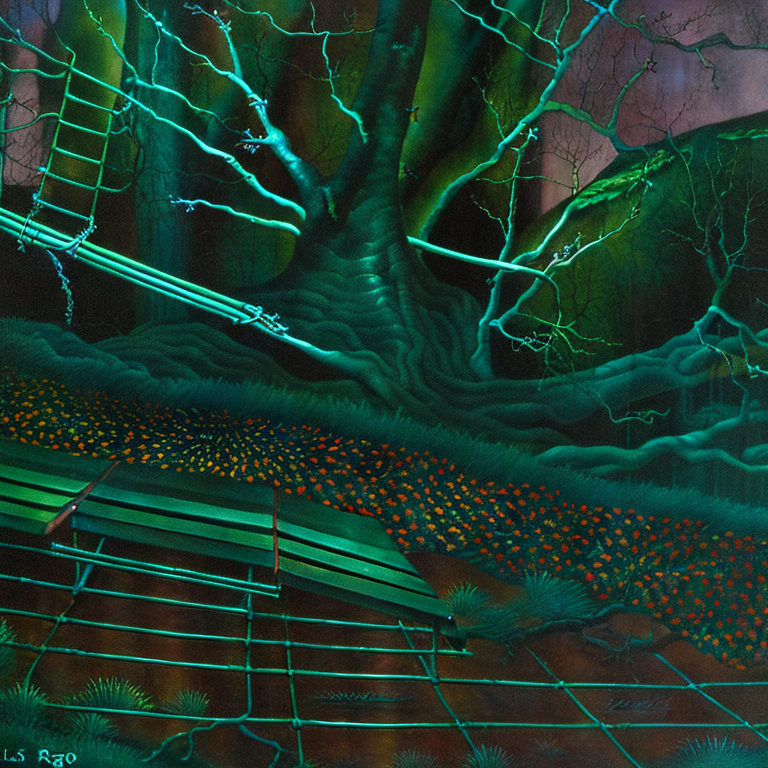

Rendering animation frame 1292 of 2000
  creating in between frame 1290 tween:0.50
  resized to 707x707
  creating in between frame 1291 tween:1.00
  resized to 707x707
  resized to 707x707


INFO:pytorch_lightning.utilities.seed:Global seed set to 3514532314


branches made of circuits in the dark, Luis Royo, hyperrealism, panorama:1, human, lowres,bad quality,signature,text:-1 3514532314
Angle: 0.0 Zoom: 1.04
Tx: 0.11921703988698855 Ty: -0.011888120318560578 Tz: 2.0
Rx: -0.003197157200315065 Ry: -0.011545970507573418 Rz: -0.005263233059452385


100%|██████████| 52/52 [00:38<00:00,  1.36it/s]


In [ ]:
prod.run_id = 5#@param {type:"number"}
prod.max_frames_user = 2000#@param {type:"number"}

# For the chosen run, how many frames before the next prompt to be marked as blend point
prod.blend_offset = 30#@param {type:"number"}

# Transition range around major prompts
prod.transition_range = 20#@param {type:"number"}

# Shuffle styles or not
prod.shuffle_styles = True#@param {type:"boolean"}


# Major prompts
# Real prompts are derived from this dict.
prod.major_prompts = {
    0 : "dark jungle full of wild plants and vegetation,dark swamp,pastel colors,colorful",
    529 : "trail in jungle full of wild plants and vegetation at night,moon,tall trees,colorful",
    625 : "trail around swamp,tall trees,moon,pastel colors,colorful",
    880 : "footpath in jungle with dense vegetation at night full of stars",
    1370 :"river passing through forest with various flowers at night full of stars",
    1900 : "branches made of electronics",
    2100 : "branches made of circuits in the dark",
    3400 : "electronics,digital world,synthesized sound",
    3600 : "forest of electricity and information",
    5400 : "plants and vegetation in jungle",
    5600 : "single plant sprouting in a dry landscape",
    6750 : "lonely dry landscape with cracks on the ground that looks like branches of a tree,cracks on the ground that looks like branches of a tree",
    8300 : "huge modern city at night seen from ground level with garbage lying around,empty streets",
    9200 : "escalator to space inside a city,dark crowded metropolitan,city at night,empty streets",
    9950 : "discoball planet in space,planet made of discoball",
}


prod.artist_list = ['Ugur Engin Deniz', 'Yetkin Yilmaz']

prod.artist_interval = 120#@param {type:"number"}

prod.style_list = ['hyperrealism', ]

prod.style_interval = 240#@param {type:"number"}

prod.positive_prompts = {
    0    : "panorama:1",
}

prod.negative_prompts = {
    0    : "human, lowres,bad quality,signature,text:-1",
}

#prod.positives = "octane render,wide angle,panorama,vibrant,very detailed,very intricate,very complex,photorealistic,8k"
#prod.positives = "panorama,vibrant,very detailed, very complex,8k"#@param {type:"string"}

#prod.negatives = "people, lowres,bad quality,signature,text"#@param {type:"string"}
#"logo,signboards,text,writing,people,oversaturated,out of focus,blur,lowres,bad quality,signature,watermark"

#prod.positives = prod.positives + ":1"
#prod.negatives = prod.negatives + ":-1"



prod.prepare_prompts()

#validate_prompts(prod.animation_prompts)

prod.run()



In [ ]:
skip_disconnect_for_run_all = True #@param {type: 'boolean'}

if skip_disconnect_for_run_all == True:
    print('Skipping disconnect, uncheck skip_disconnect_for_run_all if you want to run it')
else:
    from google.colab import runtime
    runtime.unassign()